I have consistently been confused by how I can learn the dynamics of the time series, using my own time data points (in Anode and torchdiffeq repos).

In [1]:
from cosmoNODE.loaders import Anode as A

In [2]:
from cosmoNODE.anode.models import ODEBlock, ODEFunc, ODENet
from cosmoNODE.anode.training import Trainer

In [3]:
import numpy as np
from torchdiffeq import odeint_adjoint as odeint

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
a = A()
dataloader = DataLoader(a)

In [9]:
item = a[0]
lc = item[0]
obj_class = item[1]


In [10]:
lc = lc.squeeze()
mjds = lc[:, 0]
fluxes = lc[:, 1]
zero = torch.cat((fluxes, mjds))
one_flux = fluxes[0].reshape(1, -1)
flxs = fluxes.reshape(1, -1)
print(one_flux.shape)

torch.Size([1, 1])


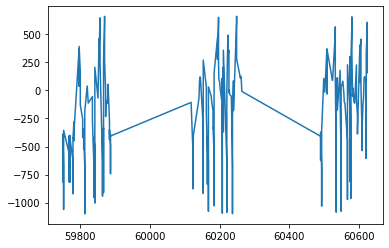

In [13]:
plt.plot(mjds.tolist(), fluxes.tolist())

In [12]:
device = torch.device('cuda:' if torch.cuda.is_available() else 'cpu')
data_dim = 1 # the data dimension should be 1 (only giving model flux)
hidden_dim = 16
output_dim = 1

func = ODEFunc(device, data_dim=data_dim, hidden_dim=hidden_dim, augment_dim=1)

In [14]:
model = ODENet(device, data_dim=data_dim, hidden_dim=hidden_dim, output_dim=output_dim, time_dependent=True)

In [15]:
block = ODEBlock(device, odefunc=func)
print(block)


ODEBlock(
  (odefunc): ODEFunc(
    (fc1): Linear(in_features=2, out_features=16, bias=True)
    (fc2): Linear(in_features=16, out_features=16, bias=True)
    (fc3): Linear(in_features=16, out_features=2, bias=True)
    (non_linearity): ReLU(inplace)
  )
)


In [27]:
fwd = block(one_flux, eval_times=mjds)
print(fwd)
fwd_fluxes = fwd[:, 0, 1]
# plt.plot(mjds.tolist(), fwd.tolist())

tensor([[[-5.4481e+02,  0.0000e+00]],

        [[-5.4443e+02, -6.6561e-01]],

        [[-5.4408e+02, -1.2924e+00]],

        [[-5.4374e+02, -1.8802e+00]],

        [[-4.5084e+02, -1.5812e+02]],

        [[-4.5043e+02, -1.5880e+02]],

        [[-4.5002e+02, -1.5947e+02]],

        [[-4.4940e+02, -1.6049e+02]],

        [[-4.4878e+02, -1.6151e+02]],

        [[ 2.0667e+03, -2.9155e+03]],

        [[ 2.0692e+03, -2.9180e+03]],

        [[ 2.0717e+03, -2.9204e+03]],

        [[ 2.0754e+03, -2.9240e+03]],

        [[ 2.0792e+03, -2.9276e+03]],

        [[ 3.1207e+03, -3.9332e+03]],

        [[ 3.1238e+03, -3.9363e+03]],

        [[ 3.1270e+03, -3.9393e+03]],

        [[ 3.1317e+03, -3.9439e+03]],

        [[ 3.1349e+03, -3.9469e+03]],

        [[ 8.5476e+03, -9.0958e+03]],

        [[ 8.5541e+03, -9.1020e+03]],

        [[ 8.5606e+03, -9.1081e+03]],

        [[ 8.5671e+03, -9.1143e+03]],

        [[ 8.5769e+03, -9.1235e+03]],

        [[ 1.1210e+04, -1.1598e+04]],

        [[ 1.1218e+04, -1

In [37]:
pred = model(fluxes[0:2])

RuntimeError: invalid argument 0: Tensors must have same number of dimensions: got 2 and 1 at /pytorch/aten/src/TH/generic/THTensor.cpp:702

In [130]:
odefunc = ODEFunc(device, data_dim, hidden_dim, augment_dim,
                  time_dependent, non_linearity)

self.odeblock = ODEBlock(device, odefunc, tol=tol, adjoint=adjoint)
self.linear_layer = nn.Linear(self.odeblock.odefunc.input_dim,
                              self.output_dim)


NameError: name 'augment_dim' is not defined

In [67]:
pred

tensor([-182.8846], grad_fn=<AddBackward0>)

In [119]:
true_y0 = torch.tensor([[2., 0.]])
true_y0.shape

torch.Size([1, 2])

In [123]:
true_y0 = torch.tensor([[2., 0.]])
t = torch.linspace(0., 25., 352)
true_A = torch.tensor([[-0.1, 2.0], [-2.0, -0.1]])


class Lambda(nn.Module):

    def forward(self, t, y):
        return torch.mm(y**3, true_A)


with torch.no_grad():
    true_y = odeint(Lambda(), true_y0, t, method='dopri5')

In [155]:
batch_time = 352  # max flux seq len
data_size = 1000
batch_size = 16


def get_batch():
    s = torch.from_numpy(np.random.choice(np.arange(50, dtype=np.int64), 1, replace=False))
    batch_y0 = true_y[s]  # (M, D)
    batch_t = t[:batch_time]  # (T)
    batch_y = torch.stack([true_y[s + i] for i in range(batch_time)], dim=0)  # (T, M, D)
    return batch_y0, batch_t, batch_y

In [188]:
np.random.choice(np.arange(50, dtype=np.int64), 2, replace=False)

array([ 8, 35])

In [156]:
batch_y0, batch_t, batch_y = get_batch()

IndexError: index 352 is out of bounds for dimension 0 with size 352